## 3

## Grid

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
201/201 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0550
Epoch 2/50
201/201 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0104
Epoch 3/50
201/201 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0090
Epoch 4/50
201/201 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0085
Epoch 5/50
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0083
Epoch 6/50
201/201 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0081
Epoch 7/50
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0081
Epoch 8/50
201/201 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0080
Epoch 9/50
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0080
Epoch 10/50
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0080
Epoch 11/50
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0080
Epoch 12/50
201/201 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0080
Epoch 13/50
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0080
Epoch 14/50
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0080
Epoch 15/50
201/201 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - lo

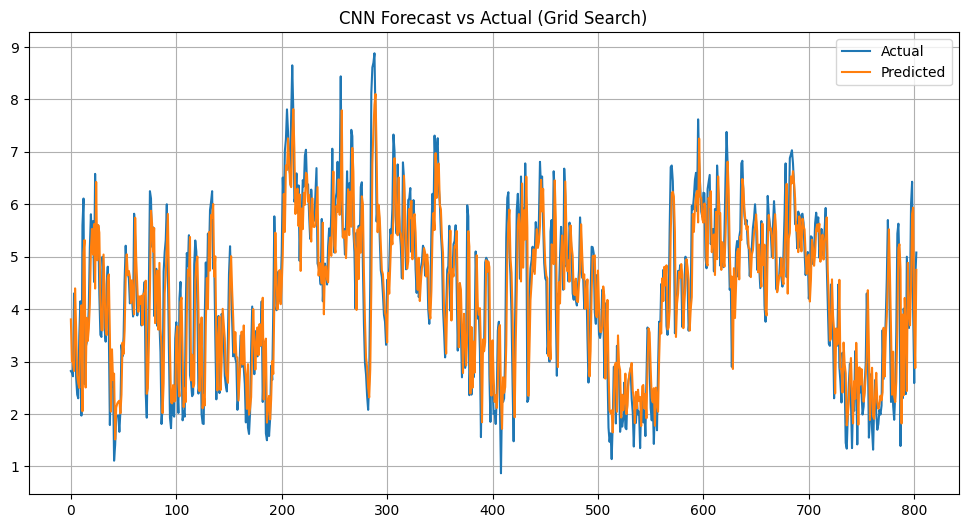

In [ ]:
import random
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import TimeSeriesSplit, ParameterGrid
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Dense, Flatten
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# Set seed
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Load data
sheet_id = "1j_Euo80PrGckVDVr2hTG9zZebxJD0TSC"
sheet_name = "Sheet1"
csv_url = f"https://docs.google.com/spreadsheets/d/{sheet_id}/gviz/tq?tqx=out:csv&sheet={sheet_name}"
df = pd.read_csv(csv_url)
df = df.set_index('Date')
df = df[['WS10M']]

# Normalize
scaler = MinMaxScaler()
df['WS10M'] = scaler.fit_transform(df[['WS10M']])

# Create sequences
def create_sequences(data, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i + window_size])
        y.append(data[i + window_size])
    return np.array(X), np.array(y)

window_size = 3
X, y = create_sequences(df['WS10M'].values, window_size)
split_index = int(len(X) * 0.8)
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]
X_train = X_train[..., np.newaxis]
X_test = X_test[..., np.newaxis]

# Grid
param_grid = {
    'filters': [32, 64,128],
    'kernel_size': [1, 2, 3],
    'lr': [1e-4, 3e-4],
    'batch_size': [8, 16, 32],
    'epochs': [10, 30, 50]
}

tscv = TimeSeriesSplit(n_splits=3)
best_loss = float('inf')
best_params = None
best_model = None

# Grid search
for params in ParameterGrid(param_grid):
    val_losses = []
    for train_idx, val_idx in tscv.split(X_train):
        X_t, X_v = X_train[train_idx], X_train[val_idx]
        y_t, y_v = y_train[train_idx], y_train[val_idx]

        model = Sequential()
        model.add(Conv1D(filters=params['filters'], kernel_size=params['kernel_size'], activation='relu', input_shape=X_train.shape[1:]))
        model.add(Flatten())
        model.add(Dense(1))
        model.compile(optimizer=Adam(learning_rate=params['lr']), loss='mse')
        model.fit(X_t, y_t, epochs=params['epochs'], batch_size=params['batch_size'], verbose=0)
        val_loss = model.evaluate(X_v, y_v, verbose=0)
        val_losses.append(val_loss)

    mean_val_loss = np.mean(val_losses)
    if mean_val_loss < best_loss:
        best_loss = mean_val_loss
        best_params = params
        best_model = model

# Final training
model = Sequential()
model.add(Conv1D(filters=best_params['filters'], kernel_size=best_params['kernel_size'], activation='relu', input_shape=X_train.shape[1:]))
model.add(Flatten())
model.add(Dense(1))
model.compile(optimizer=Adam(learning_rate=best_params['lr']), loss='mse')
model.fit(X_train, y_train, epochs=best_params['epochs'], batch_size=best_params['batch_size'], verbose=1)

# Evaluation
y_pred = model.predict(X_test)
y_pred_inv = scaler.inverse_transform(y_pred)
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))

mse = mean_squared_error(y_test_inv, y_pred_inv)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_inv, y_pred_inv)
mape = np.mean(np.abs((y_test_inv - y_pred_inv) / y_test_inv)) * 100
r2 = r2_score(y_test_inv, y_pred_inv)

# Results
print(f"Best Parameters: {best_params}")
print(f" Test MSE  : {mse:.4f}")
print(f" Test RMSE : {rmse:.4f}")
print(f" Test MAE  : {mae:.4f}")
print(f" Test MAPE : {mape:.2f}%")
print(f" Test R²   : {r2:.4f}")

plt.figure(figsize=(12, 6))
plt.plot(y_test_inv, label='Actual')
plt.plot(y_pred_inv, label='Predicted')
plt.title('CNN Forecast vs Actual (Grid Search)')
plt.legend()
plt.grid(True)
plt.show()


## Random

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/48
402/402 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.1144
Epoch 2/48
402/402 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0121
Epoch 3/48
402/402 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0097
Epoch 4/48
402/402 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0088
Epoch 5/48
402/402 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0084
Epoch 6/48
402/402 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0082
Epoch 7/48
402/402 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0081
Epoch 8/48
402/402 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0081
Epoch 9/48
402/402 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0080
Epoch 10/48
402/402 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0080
Epoch 11/48
402/402 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0080
Epoch 12/48
402/402 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0080
Epoch 13/48
402/402 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0080
Epoch 14/48
402/402 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0080
Epoch 15/48
402/402 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - lo

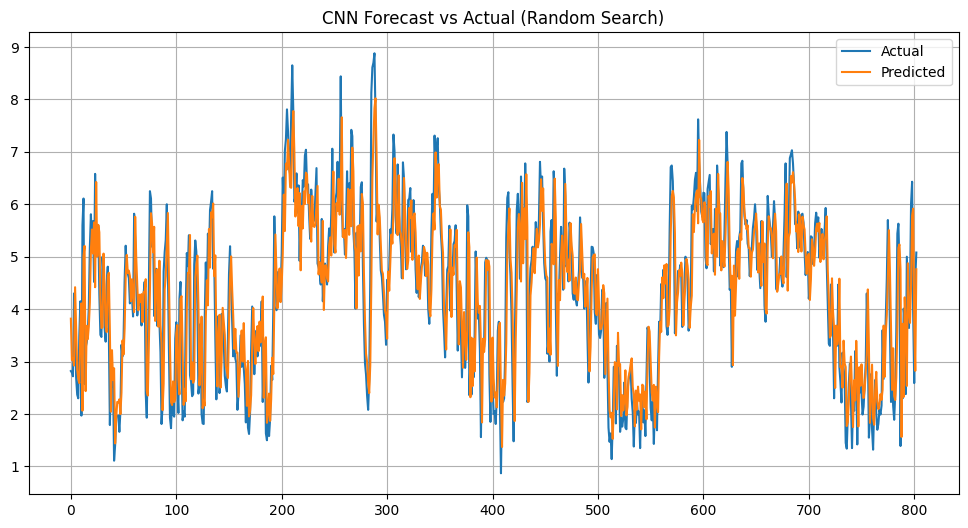

In [ ]:
import random
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import TimeSeriesSplit, ParameterSampler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Dense, Flatten
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from scipy.stats import randint, uniform
from scipy.stats import loguniform

# Set seed
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Load data
sheet_id = "1j_Euo80PrGckVDVr2hTG9zZebxJD0TSC"
sheet_name = "Sheet1"
csv_url = f"https://docs.google.com/spreadsheets/d/{sheet_id}/gviz/tq?tqx=out:csv&sheet={sheet_name}"
df = pd.read_csv(csv_url)
df = df.set_index('Date')
df = df[['WS10M']]

# Normalize
scaler = MinMaxScaler()
df['WS10M'] = scaler.fit_transform(df[['WS10M']])

# Create sequences
def create_sequences(data, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i + window_size])
        y.append(data[i + window_size])
    return np.array(X), np.array(y)

window_size = 3
X, y = create_sequences(df['WS10M'].values, window_size)
split_index = int(len(X) * 0.8)
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]
X_train = X_train[..., np.newaxis]
X_test = X_test[..., np.newaxis]

# Define hyperparameter search space
param_dist = {
    'filters': randint(32, 129),                   # Integers from 32 to 128
    'kernel_size': randint(1, 4),                  # Integers 1 to 3
    'lr': loguniform(1e-4, 1e-2),                  # Log scale for learning rate
    'batch_size': [8, 16, 32],
    'epochs': randint(10, 51)
}

n_iter_search = 10  # Number of random combinations to try
random_search = list(ParameterSampler(param_dist, n_iter=n_iter_search, random_state=SEED))

tscv = TimeSeriesSplit(n_splits=5)
best_loss = float('inf')
best_params = None
best_model = None

# Random Search
for params in random_search:
    val_losses = []
    for train_idx, val_idx in tscv.split(X_train):
        X_t, X_v = X_train[train_idx], X_train[val_idx]
        y_t, y_v = y_train[train_idx], y_train[val_idx]

        model = Sequential()
        model.add(Conv1D(filters=params['filters'], kernel_size=params['kernel_size'], activation='relu', input_shape=X_train.shape[1:]))
        model.add(Flatten())
        model.add(Dense(1))
        model.compile(optimizer=Adam(learning_rate=params['lr']), loss='mse')
        model.fit(X_t, y_t, epochs=params['epochs'], batch_size=params['batch_size'], verbose=0)
        val_loss = model.evaluate(X_v, y_v, verbose=0)
        val_losses.append(val_loss)

    mean_val_loss = np.mean(val_losses)
    if mean_val_loss < best_loss:
        best_loss = mean_val_loss
        best_params = params
        best_model = model

# Final training on all training data
model = Sequential()
model.add(Conv1D(filters=best_params['filters'], kernel_size=best_params['kernel_size'], activation='relu', input_shape=X_train.shape[1:]))
model.add(Flatten())
model.add(Dense(1))
model.compile(optimizer=Adam(learning_rate=best_params['lr']), loss='mse')
model.fit(X_train, y_train, epochs=best_params['epochs'], batch_size=best_params['batch_size'], verbose=1)

# Evaluation
y_pred = model.predict(X_test)
y_pred_inv = scaler.inverse_transform(y_pred)
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))

mse = mean_squared_error(y_test_inv, y_pred_inv)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_inv, y_pred_inv)
mape = np.mean(np.abs((y_test_inv - y_pred_inv) / y_test_inv)) * 100
r2 = r2_score(y_test_inv, y_pred_inv)

# Results
print(f"Best Parameters (Random Search): {best_params}")
print(f" Test MSE  : {mse:.4f}")
print(f" Test RMSE : {rmse:.4f}")
print(f" Test MAE  : {mae:.4f}")
print(f" Test MAPE : {mape:.2f}%")
print(f" Test R²   : {r2:.4f}")

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(y_test_inv, label='Actual')
plt.plot(y_pred_inv, label='Predicted')
plt.title('CNN Forecast vs Actual (Random Search)')
plt.legend()
plt.grid(True)
plt.show()


## Optuna

In [ ]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 395.9/395.9 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.7/242.7 kB 14.2 MB/s eta 0:00:00


                     WS10M
Date                      
2013-01-01 00:00:00   3.99
2013-01-02 00:00:00   4.25
2013-01-03 00:00:00   4.75
2013-01-04 00:00:00   5.74
2013-01-05 00:00:00   5.79
Index(['2013-01-01 00:00:00', '2013-01-02 00:00:00', '2013-01-03 00:00:00',
       '2013-01-04 00:00:00', '2013-01-05 00:00:00', '2013-01-06 00:00:00',
       '2013-01-07 00:00:00', '2013-01-08 00:00:00', '2013-01-09 00:00:00',
       '2013-01-10 00:00:00',
       ...
       '2023-12-22 00:00:00', '2023-12-23 00:00:00', '2023-12-24 00:00:00',
       '2023-12-25 00:00:00', '2023-12-26 00:00:00', '2023-12-27 00:00:00',
       '2023-12-28 00:00:00', '2023-12-29 00:00:00', '2023-12-30 00:00:00',
       '2023-12-31 00:00:00'],
      dtype='object', name='Date', length=4017)


[I 2025-07-08 02:54:47,982] A new study created in memory with name: no-name-0c4b503d-fe1f-4c07-9316-9b2c0a09cc70
[I 2025-07-08 02:55:46,354] Trial 0 finished with value: 0.008593770985802015 and parameters: {'filters': 68, 'kernel_size': 3, 'lr': 0.0029106359131330704, 'epochs': 34, 'batch_size': 8}. Best is trial 0 with value: 0.008593770985802015.
[I 2025-07-08 02:56:06,402] Trial 1 finished with value: 0.008672063704580069 and parameters: {'filters': 116, 'kernel_size': 2, 'lr': 0.0026070247583707684, 'epochs': 10, 'batch_size': 8}. Best is trial 0 with value: 0.008593770985802015.
[I 2025-07-08 02:56:29,264] Trial 2 finished with value: 0.008853446847448746 and parameters: {'filters': 49, 'kernel_size': 1, 'lr': 0.0004059611610484307, 'epochs': 31, 'batch_size': 32}. Best is trial 0 with value: 0.008593770985802015.
[I 2025-07-08 02:57:16,211] Trial 3 finished with value: 0.008551078382879496 and parameters: {'filters': 45, 'kernel_size': 1, 'lr': 0.0005404103854647331, 'epochs': 

Best trial: {'filters': 110, 'kernel_size': 2, 'lr': 0.000581448807200837, 'epochs': 44, 'batch_size': 8}
Epoch 1/44
402/402 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0430
Epoch 2/44
402/402 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0090
Epoch 3/44
402/402 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0082
Epoch 4/44
402/402 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0081
Epoch 5/44
402/402 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0080
Epoch 6/44
402/402 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0080
Epoch 7/44
402/402 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0080
Epoch 8/44
402/402 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0080
Epoch 9/44
402/402 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0080
Epoch 10/44
402/402 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0080
Epoch 11/44
402/402 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0080
Epoch 12/44
402/402 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0080
Epoch 13/44
402/402 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0080
Epoch 14/44
402/402

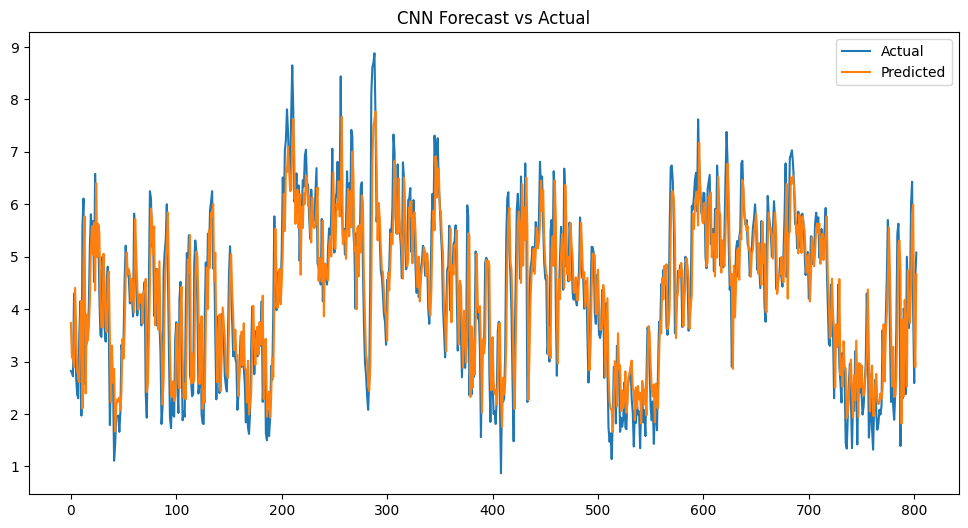

In [ ]:
# Standard libraries
import sys  # System-specific parameters and functions
import os   # Miscellaneous operating system interfaces
import warnings  # Warning control
warnings.filterwarnings("ignore")

# Data manipulation
import pandas as pd  # Data manipulation and analysis
import numpy as np  # Numerical operations

# LOADING THE DATASET
import gdown

import pandas as pd

# Updated Google Sheets link setup
sheet_id = "1j_Euo80PrGckVDVr2hTG9zZebxJD0TSC"
sheet_name = "Sheet1"  # Update this if the sheet name is different

# Generate the CSV export link
csv_url = f"https://docs.google.com/spreadsheets/d/{sheet_id}/gviz/tq?tqx=out:csv&sheet={sheet_name}"

# Read the Google Sheet as CSV
df = pd.read_csv(csv_url)

# Backup original DataFrame
df_backup = df.copy()


# Set Date as the index
df = df.set_index('Date')

# Display the DataFrame (optional in scripts)
df.head()
df_backup=df.copy()

df = df[['WS10M']]

# Display the first few rows to verify changes
print(df.head())

# Check the updated index
print(df.index)
df
! pip install optuna
!pip install optuna
!pip install scikit-learn
!pip install tensorflow
# After all imports
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
#optuna.seed = SEED  # Optional fallback
from optuna.samplers import TPESampler

import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# Rename for ease if necessary
target_column ="WS10M" # e.g., "Inflation"

# Normalize the data
scaler = MinMaxScaler()
df[target_column] = scaler.fit_transform(df[[target_column]])

# Convert to supervised learning format
def create_sequences(data, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i + window_size])
        y.append(data[i + window_size])
    return np.array(X), np.array(y)

# Define window size
window_size = 3  # Monthly data (1 year of past data to predict next month)  #################################################################

# Prepare input/output
X, y = create_sequences(df[target_column].values, window_size)

split_index = int(len(X) * 0.8)
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

# Reshape for CNN [samples, time steps, features]
X_train = X_train[..., np.newaxis]
X_test = X_test[..., np.newaxis]

import optuna
from sklearn.model_selection import TimeSeriesSplit
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Dense, Flatten
from tensorflow.keras.optimizers import Adam

def create_model(trial, input_shape):
    model = Sequential()
    model.add(Conv1D(filters=trial.suggest_int('filters', 32, 128),
                     kernel_size=trial.suggest_int('kernel_size', 1, 3), #################################################################
                     activation='relu',
                     input_shape=input_shape))
    model.add(Flatten())
    model.add(Dense(1))
    model.compile(optimizer=Adam(learning_rate=trial.suggest_loguniform('lr', 1e-4, 1e-2)),
                  loss='mse')
    return model

def objective(trial):
    tscv = TimeSeriesSplit(n_splits=3)
    val_losses = []

    for train_idx, val_idx in tscv.split(X_train):
        X_t, X_v = X_train[train_idx], X_train[val_idx]
        y_t, y_v = y_train[train_idx], y_train[val_idx]

        model = create_model(trial, input_shape=X_train.shape[1:])
        model.fit(X_t, y_t, epochs=trial.suggest_int('epochs', 10, 50), verbose=0, batch_size=trial.suggest_categorical('batch_size', [8, 16, 32]))

        val_loss = model.evaluate(X_v, y_v, verbose=0)
        val_losses.append(val_loss)

    return np.mean(val_losses)

# Run Optuna study

# Your existing Optuna study call
study = optuna.create_study(direction='minimize', sampler=TPESampler(seed=SEED))


#study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=30)

print('Best trial:', study.best_trial.params)

# Train final model
best_params = study.best_trial.params
model = Sequential()
model.add(Conv1D(filters=best_params['filters'],
                 kernel_size=best_params['kernel_size'],
                 activation='relu',
                 input_shape=X_train.shape[1:]))
model.add(Flatten())
model.add(Dense(1))
model.compile(optimizer=Adam(learning_rate=best_params['lr']),
              loss='mse')

model.fit(X_train, y_train, epochs=best_params['epochs'], batch_size=best_params['batch_size'], verbose=1)

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Predict and inverse transform
y_pred = model.predict(X_test)
y_pred_inv = scaler.inverse_transform(y_pred)
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))

# Calculate metrics
mse = mean_squared_error(y_test_inv, y_pred_inv)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_inv, y_pred_inv)
mape = np.mean(np.abs((y_test_inv - y_pred_inv) / y_test_inv)) * 100
r2 = r2_score(y_test_inv, y_pred_inv)

# Print results
print(f" Test MSE  : {mse:.4f}")
print(f" Test RMSE : {rmse:.4f}")
print(f" Test MAE  : {mae:.4f}")
print(f" Test MAPE : {mape:.2f}%")
print(f" Test R²   : {r2:.4f}")

plt.figure(figsize=(12, 6))
plt.plot(y_test_inv, label='Actual')
plt.plot(y_pred_inv, label='Predicted')
plt.title('CNN Forecast vs Actual')
plt.legend()
plt.show()




In [ ]:
df

,WS10M
Date,
2013-01-01 00:00:00,0.356164
2013-01-02 00:00:00,0.385845
2013-01-03 00:00:00,0.442922
2013-01-04 00:00:00,0.555936
2013-01-05 00:00:00,0.561644
...,...
2023-12-27 00:00:00,0.634703
2023-12-28 00:00:00,0.349315
2023-12-29 00:00:00,0.196347
